<a href="https://colab.research.google.com/github/ryali93/utilitarios/blob/master/agol/agol2shp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fiona
!pip install geopandas

In [ ]:
import os, requests
import json, uuid
import pandas as pd
import geopandas as gpd

nombreSHP = "gpo_cartas_ign"
url = 'https://geocatmin.ingemmet.gob.pe/arcgis/rest/services/SERV_CARTA_IGN/MapServer/0/query'

class RequestDataAGOL(object):
    def __init__(self):
        self.url = url
        self.listaOids = []
        
    def countOnly(self):
        response = requests.post(
            self.url,
            data = {
            'where': '1=1',
            'outFields': "*",
            'returnCountOnly': 'true',
            'f': 'pjson'
            }
        )
        res = json.loads(response.text)
        self.cantidad = res["count"]
        print(self.cantidad)

    def oidsOnly(self):
        response = requests.post(
            self.url,
            data = {
            'where': "1=1",
            'outFields': "*",
            'returnIdsOnly': 'true',
            'f': 'pjson'
            }
        )
        res = json.loads(response.text)
        self.listaOids.extend(res["objectIds"])
        self.listaOids = list(set(self.listaOids))

    def requestData(self):
        global nombreSHP
        data = self.listaOids
        chunks = [data[x:x+1000] for x in range(0, len(data), 1000)]
        geo_df = ""
        a = 0
        for n in chunks[:20]:
          a += 1
          try:
#             print(len(n))
            n = ','.join([str(x) for x in n])
            response = requests.post(
                self.url,
                data = {
                'objectIds': n,
                'outFields': "*",
                'f': 'geojson'
                }
            )
            res = json.loads(response.text)

            gdf = gpd.GeoDataFrame.from_features(res['features'])
            gdf.crs = {'init' :'epsg:4326'}
            if type(geo_df) == str:
              geo_df = gdf[:]
            else:
              geo_df = geo_df.append(gdf)

            print("geo_df tiene {} elementos".format(len(geo_df)))

            geo_df.to_file(driver="ESRI Shapefile", filename="{}.shp".format(nombreSHP))
          except:
            nombreSHP = "{}_{}".format(nombreSHP, a)


    def main(self):
        self.countOnly()
        self.oidsOnly()
        self.requestData()

if __name__ == '__main__':
    poo = RequestDataAGOL()
    poo.main()

In [6]:
import os
from zipfile import ZipFile

files_to_zip = [x for x in os.listdir() if nombreSHP in x]
with ZipFile('{}.zip'.format(nombreSHP), 'w') as zipObj:
    for filename in files_to_zip:
        zipObj.write(filename, os.path.basename(filename))

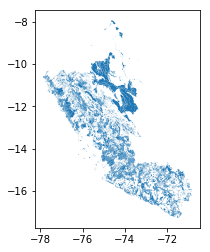

In [ ]:
gdf = gpd.read_file("{}.shp".format(nombreSHP))
gdf.plot()

In [ ]:
len(gdf)

18000